In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = '/Users/akhireddy/Downloads/AAI/AI-Project/Dataset-1/'
full_data = datasets.ImageFolder(data_dir, transform=train_transforms)

In [5]:
dataset_size = len(full_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

In [6]:
batch_sizes = [16, 32, 64]
learning_rates = [0.0001, 0.001,0.01]
param_grid = list(product(batch_sizes, learning_rates))

# Initialize variables to store best results
best_model = None
best_accuracy = 0.0
best_params = None
results = []

In [7]:
for batch_size, lr in param_grid:
    print(f"Training with Batch Size: {batch_size}, Learning Rate: {lr}")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Load pre-trained ResNet18
    resnet18 = models.resnet18(weights='IMAGENET1K_V1')
    for name, param in resnet18.named_parameters():
        if 'layer4' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    num_classes = len(test_loader.dataset.classes)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    resnet18 = resnet18.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet18.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Validation
        resnet18.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = resnet18(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = val_correct / val_total * 100
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = resnet18
            best_params = (batch_size, lr)

    results.append((batch_size, lr, val_accuracy))

Training with Batch Size: 16, Learning Rate: 0.0001
Epoch 1/10, Validation Accuracy: 78.72%
Epoch 2/10, Validation Accuracy: 78.97%
Epoch 3/10, Validation Accuracy: 79.48%
Epoch 4/10, Validation Accuracy: 78.04%
Epoch 5/10, Validation Accuracy: 76.27%
Epoch 6/10, Validation Accuracy: 77.11%
Epoch 7/10, Validation Accuracy: 73.06%
Epoch 8/10, Validation Accuracy: 75.51%
Epoch 9/10, Validation Accuracy: 73.31%
Epoch 10/10, Validation Accuracy: 71.96%
Training with Batch Size: 16, Learning Rate: 0.001
Epoch 1/10, Validation Accuracy: 74.58%
Epoch 2/10, Validation Accuracy: 79.48%
Epoch 3/10, Validation Accuracy: 78.97%
Epoch 4/10, Validation Accuracy: 78.97%
Epoch 5/10, Validation Accuracy: 79.48%
Epoch 6/10, Validation Accuracy: 79.48%
Epoch 7/10, Validation Accuracy: 77.96%
Epoch 8/10, Validation Accuracy: 79.48%
Epoch 9/10, Validation Accuracy: 79.39%
Epoch 10/10, Validation Accuracy: 79.31%
Training with Batch Size: 16, Learning Rate: 0.01
Epoch 1/10, Validation Accuracy: 79.48%
Epoch

In [8]:
print("\nBest Parameters:")
print(f"Batch Size: {best_params[0]}, Learning Rate: {best_params[1]}")

train_loader = DataLoader(train_data, batch_size=best_params[0], shuffle=True)
val_loader = DataLoader(val_data, batch_size=best_params[0])
test_loader = DataLoader(test_data, batch_size=best_params[0])

resnet18 = models.resnet18(weights='IMAGENET1K_V1')
for name, param in resnet18.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_classes = len(test_loader.dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=best_params[1])
num_epochs = 10
for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Validation
    resnet18.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet18(val_inputs)
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_accuracy = val_correct / val_total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")


Best Parameters:
Batch Size: 32, Learning Rate: 0.001
Epoch 1/10, Validation Accuracy: 79.48%
Epoch 2/10, Validation Accuracy: 79.48%
Epoch 3/10, Validation Accuracy: 79.48%
Epoch 4/10, Validation Accuracy: 79.31%
Epoch 5/10, Validation Accuracy: 79.39%
Epoch 6/10, Validation Accuracy: 78.89%
Epoch 7/10, Validation Accuracy: 79.39%
Epoch 8/10, Validation Accuracy: 79.14%
Epoch 9/10, Validation Accuracy: 78.55%
Epoch 10/10, Validation Accuracy: 76.86%



Testing the best model...
Test Accuracy: 81.19%
Precision: 78.09%
Recall: 81.19%
F1 Score: 76.56%


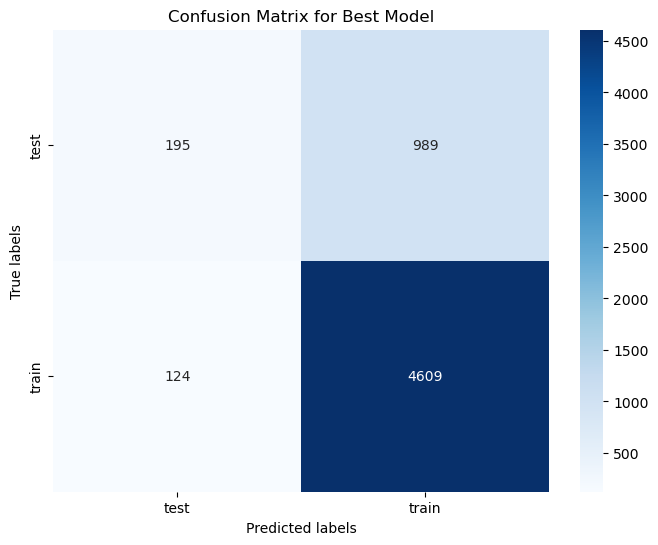

In [9]:
print("\nTesting the best model...")
resnet18.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()